[View in Colaboratory](https://colab.research.google.com/github/gitgash/test_qa/blob/master/test_estimator.ipynb)

# Introduction
This work have been proceed as test job for quantitative analyst.  
Requirements:  
get [train data](https://www.dropbox.com/s/2hqoisbqzzgym26/train.csv?dl=1) 
get [test data](https://www.dropbox.com/s/y9tbmdqtlclobgp/test.csv?dl=1) 
get [Sample prediction](https://www.dropbox.com/s/r5qu2ornfinrt1s/sample_prediction.csv?dl=1) 

and make estimator with highest AUC ROC metric.  

During  this work it have been done: 
1. data exploration,
1. 'traditional' model creation 
1. artificial neural network model creation.

Results considered in conclusion section.  
Google (tm) [Colab.research](https://colab.research.google.com) have been used in this work, but methodology and technology (jupyter notebook) tools can be used in any suitable environment (python, scikit learn, pandas, numpy, tensorflow, keras).  
Style of the work is reproducible  - anybody can run this notebook and reproduce results.  
So lets start.

# Data Exploration
In process of data exploration following steps have been proceed:
1. Loading data
1. Simple exploration
1. Correlation analysis


## Load data
Data file have been place to dropbox so we load them from there by url.

In [1]:
# It is preleminary section where we include part of libraries used later 
# and define utility functions
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools


# Plot confision matrix function
# (c) by scikit lear documentation and examples
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Using TensorFlow backend.


We use side library to upsample imbalanced test set (later explained) - so we need to install it:

In [2]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /usr/local/lib/python3.6/dist-packages (0.3.3)


In [0]:
# load dataset into pandas dataframe

train_df = pd.read_csv("https://www.dropbox.com/s/2hqoisbqzzgym26/train.csv?dl=1")
test_df = pd.read_csv("https://www.dropbox.com/s/y9tbmdqtlclobgp/test.csv?dl=1")
sample_df = pd.read_csv("https://www.dropbox.com/s/r5qu2ornfinrt1s/sample_prediction.csv?dl=1")

## Simple data exploration

In [0]:
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186590 entries, 0 to 186589
Data columns (total 21 columns):
VASK0         186590 non-null int64
VASK1         186590 non-null int64
VASK2         186590 non-null int64
VASK3         186590 non-null int64
VASK4         186590 non-null int64
VBID0         186590 non-null int64
VBID1         186590 non-null int64
VBID2         186590 non-null int64
VBID3         186590 non-null int64
VBID4         186590 non-null int64
VASK0_PREV    186590 non-null int64
VASK1_PREV    186590 non-null int64
VASK2_PREV    186590 non-null int64
VASK3_PREV    186590 non-null int64
VASK4_PREV    186590 non-null int64
VBID0_PREV    186590 non-null int64
VBID1_PREV    186590 non-null int64
VBID2_PREV    186590 non-null int64
VBID3_PREV    186590 non-null int64
VBID4_PREV    186590 non-null int64
Y             186590 non-null int64
dtypes: int64(21)
memory usage: 29.9 MB


,VASK0,VASK1,VASK2,VASK3,VASK4,VBID0,VBID1,VBID2,VBID3,VBID4,...,VASK1_PREV,VASK2_PREV,VASK3_PREV,VASK4_PREV,VBID0_PREV,VBID1_PREV,VBID2_PREV,VBID3_PREV,VBID4_PREV,Y
0,108,276,224,196,195,132,181,253,207,185,...,276,224,196,195,136,181,253,207,185,0
1,47,132,197,236,188,81,146,193,169,192,...,132,197,236,188,81,146,193,169,192,0
2,93,172,193,226,232,33,128,168,145,140,...,172,193,226,232,33,128,168,145,140,0
3,62,104,169,188,140,75,165,151,206,105,...,104,169,188,140,81,165,151,206,105,0
4,40,43,87,110,99,11,66,77,155,364,...,43,87,110,99,11,66,77,153,364,0


186590 examples -  not bad for deep learning  
'Y' column contains label.  
21 columns, 1 - label so we have 20 features.  
Features are finteger  
Lets look on the features: 

In [0]:
# Looking for names
for s in train_df.columns[0:-1]:
    print("%s\t%d" % (s, train_df[s].count()))

VASK0	186590
VASK1	186590
VASK2	186590
VASK3	186590
VASK4	186590
VBID0	186590
VBID1	186590
VBID2	186590
VBID3	186590
VBID4	186590
VASK0_PREV	186590
VASK1_PREV	186590
VASK2_PREV	186590
VASK3_PREV	186590
VASK4_PREV	186590
VBID0_PREV	186590
VBID1_PREV	186590
VBID2_PREV	186590
VBID3_PREV	186590
VBID4_PREV	186590


As been said in description there are top 5 bids and asks for current time and previous moment.     
No NaN values in columns.   
What about labels?  

count    186590.000000
mean          0.010258
std           0.100760
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Y, dtype: float64


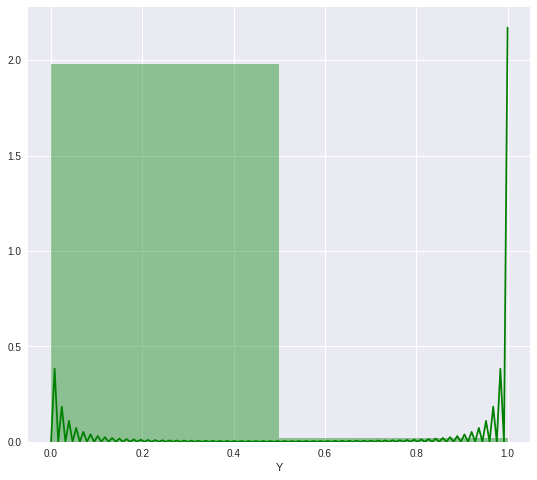

In [0]:
print(train_df['Y'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(train_df['Y'], color='g', bins=2, hist_kws={'alpha': 0.4});

Labels are strongly imbalanced: class '1' prevails over 0.  


# Correlation analisys

In [0]:
# calculate correlation matrix and get 'label' correlation column
df_num_corr = train_df.corr()['Y'][:-1]
# get absolute value of correlation
abs_corr = abs(df_num_corr)
# sort and get top 20
abs_corr.sort_values(ascending=False).head(20)

VBID0         0.025155
VASK0         0.024026
VBID0_PREV    0.023590
VASK0_PREV    0.022126
VBID1         0.007163
VBID1_PREV    0.007082
VBID3_PREV    0.006144
VBID3         0.006133
VASK1         0.005619
VASK1_PREV    0.005569
VASK4_PREV    0.004739
VASK4         0.004727
VASK3         0.004548
VASK3_PREV    0.004537
VASK2         0.004106
VASK2_PREV    0.004067
VBID2         0.003978
VBID2_PREV    0.003969
VBID4_PREV    0.003783
VBID4         0.003782
Name: Y, dtype: float64

Correlation is week

## What about test data?

In [0]:
test_df.head()

,VASK0,VASK1,VASK2,VASK3,VASK4,VBID0,VBID1,VBID2,VBID3,VBID4,VASK0_PREV,VASK1_PREV,VASK2_PREV,VASK3_PREV,VASK4_PREV,VBID0_PREV,VBID1_PREV,VBID2_PREV,VBID3_PREV,VBID4_PREV
0,187,341,385,375,323,134,158,213,222,180,187,341,385,375,323,134,158,212,222,180
1,37,165,144,160,146,89,101,184,162,123,38,165,144,160,146,89,101,185,162,123
2,195,192,211,178,188,18,114,162,163,167,195,192,211,178,188,18,114,162,163,167
3,5,180,143,159,194,109,127,224,133,132,5,180,143,159,194,110,127,224,133,132
4,117,156,154,169,139,48,129,148,159,177,117,156,154,169,139,48,128,148,159,177


No target - the rest is the same as train

## What about sample?

In [0]:
sample_df.head()

,Y_PRED
0,0.0
1,0.5
2,1.0
3,0.0
4,0.5


Y_PRED have to be float - as beleive of value to be 1

# Build Estimators

In [0]:
# crete X and y
X = train_df.iloc[:,0:-1].copy()
y = train_df['Y']

# divide to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=3623467829)

# preprocess features
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# balance train set
# from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from collections import Counter
X_resampled, y_resampled = SMOTEENN().fit_sample(X_train, y_train)
X_train = X_resampled
y_train = y_resampled


In [0]:
from sklearn import metrics
from keras import backend as K

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc
  

In [62]:

# model
model = Sequential()
model.add(Dense(512, activation='relu', input_dim=20))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss="binary_crossentropy", optimizer='adam', metrics=[auc])
model.fit(X_train, y_train,
          batch_size=32, epochs=5, verbose=1)
  



Epoch 1/5
319765/319765 [==============================] - 158s 493us/step - loss: 0.4070 - auc: 0.8678
Epoch 2/5
319765/319765 [==============================] - 156s 489us/step - loss: 0.3552 - auc: 0.8999
Epoch 3/5
319765/319765 [==============================] - 157s 490us/step - loss: 0.3287 - auc: 0.9099
Epoch 4/5
319765/319765 [==============================] - 158s 493us/step - loss: 0.3111 - auc: 0.9167
Epoch 5/5
319765/319765 [==============================] - 159s 498us/step - loss: 0.3006 - auc: 0.9218


AUC ROC  0.854421
Confusion matrix, without normalization
[[14708  3757]
 [   42   152]]


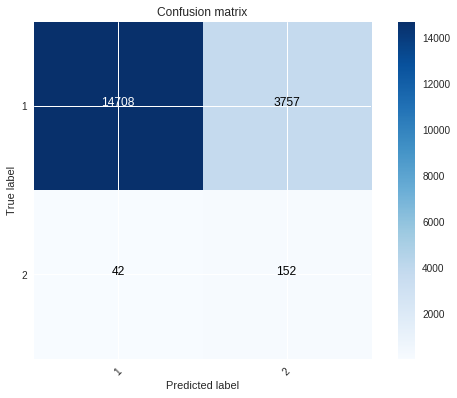

In [66]:
# make prediction on test set
X_test_2 = scaler.transform(X_test)

y_pred = model.predict(X_test_2)
# calculate score
print("AUC ROC  %f" % roc_auc_score(y_test, y_pred))

y_pred1 = np.rint(y_pred[:,0])

cnf_matrix = confusion_matrix(y_test, y_pred1)
plot_confusion_matrix(cnf_matrix,[1,2])

Macro score is 0.278116, weighted score is 0.375937.  
This is a little  better then dummy classifier macro score 0.212425 and weighted score 0.323443.  



# Future work
Presumably neural network approach can provide better results.  
Key development directions:  
1. Try deep architectures with [regularizers](https://keras.io/regularizers/)
1. Make CNN with convolutions based on 'fX__rY - groups of features. Convolutions in image classification extruct base features from 2d-local regions, so hypotheses  is to extract  base features of provided data from fX groups of features (that presumably grouped in some space)
1. Fit autoencoders on fX__rY groups of features and use them as input layer for 2-3 fully connected layers